In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
image_train = 'tracking_processed_train.pkl'
label_train = 'label_processed_train.pkl'

In [ ]:
# Define the CNN-LSTM model with multiple independent output classifiers
class CNN_LSTM_MultiOutput_Model(nn.Module):
    def __init__(self, input_size=9216, hidden_dim=512, class_pa=2, class_rpo=2,
                 class_of=9, class_rf=12, class_pt=31, class_pc=20, class_rc=140,
                 class_os=2, num_lstm_layers=2):
        super(CNN_LSTM_MultiOutput_Model, self).__init__()
        
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #, stride=2)
        )
        
        # LSTM part
        self.lstm = nn.LSTM(input_size, hidden_dim, num_lstm_layers, batch_first=True)
        
        # Output classifiers (separate for each task)
        self.fc_pa = nn.Linear(hidden_dim, class_pa)  # Output 1 (classification task)
        self.fc_rpo = nn.Linear(hidden_dim, class_rpo)  # Output 2 (classification task)
        self.fc_of = nn.Linear(hidden_dim, class_of)  # Output 3 (multi-label classification)
        self.fc_rf = nn.Linear(hidden_dim, class_rf)  # Output 1 (classification task)
        self.fc_pt = nn.Linear(hidden_dim, class_pt)  # Output 2 (classification task)
        self.fc_pc = nn.Linear(hidden_dim, class_pc)  # Output 3 (multi-label classification)
        self.fc_rc = nn.Linear(hidden_dim, class_rc)  # Output 2 (classification task)
        self.fc_os = nn.Linear(hidden_dim, class_os)  # Output 3 (multi-label classification)
    
    def forward(self, x):
        # x: (batch_size, seq_len, channels, height, width)
        batch_size, seq_len, channels, height, width = x.size()
        
        # assert len(channels)==1
        
        # Apply CNN to each frame in the sequence
        cnn_out = []
        for i in range(seq_len):
            frame = x[:, i, :, :, :]  # Get the ith frame
            frame_features = self.cnn(frame) # Apply CNN to the frame
            frame_features = frame_features.view(frame_features.size(0), -1)  # Flatten the output
            cnn_out.append(frame_features)
        
        # Stack CNN outputs to form the sequence of feature vectors
        cnn_out = torch.stack(cnn_out, dim=1)  # (batch_size, seq_len, feature_size)
        
        # Pass the CNN features into the LSTM
        lstm_out, _ = self.lstm(cnn_out)  # (batch_size, seq_len, hidden_dim)
        
        # Use the output of the LSTM for the last time step
        last_hidden_state = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
                
        # Pass through separate fully connected layers for each output task
        out_pa = self.fc_pa(last_hidden_state)  # Output 1 (e.g., classification task)
        out_rpo = self.fc_rpo(last_hidden_state)  # Output 2 (e.g., classification task)
        out_of = self.fc_of(last_hidden_state)  # Output 3 (e.g., multi-label classification)
        out_rf = self.fc_rf(last_hidden_state)  # Output 1 (e.g., classification task)
        out_pt = self.fc_pt(last_hidden_state)  # Output 2 (e.g., classification task)
        out_pc = self.fc_pc(last_hidden_state)  # Output 3 (e.g., multi-label classification)
        out_rc = self.fc_rc(last_hidden_state)  # Output 1 (e.g., classification task)
        out_os = self.fc_os(last_hidden_state)  # Output 2 (e.g., classification task)
        
        return out_pa, out_rpo, out_of, out_rf, out_pt, out_pc, out_rc, out_os

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import OrderedDict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Assuming the `CNN_LSTM_MultiOutput_Model` and `SequentialImageDataset` are already defined
# and the model has been trained previously.
model = CNN_LSTM_MultiOutput_Model()
state_dict = torch.load('NFL_CNN_LSTM.pth')
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict) #torch.load('NFL_CNN_LSTM.pth', weights_only=True)
# model.eval()

/tmp/ipykernel_207953/718645767.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('NFL_CNN_LSTM.pth')


<All keys matched successfully>

In [ ]:
class SequentialImageDataset(Dataset):
    def __init__(self, image_dir, label_file, seq_length=350, transform=None):
        self.image_dir = image_dir
        self.label_file = label_file
        self.transform = transform
        self.seq_length = seq_length
        
        self.frames = pd.read_pickle(image_dir)
        print(len(np.unique(self.frames['game_play'])), flush=True)
        self.labels = pd.read_pickle(label_file)
        self.ids = np.unique(self.labels['game_play'])
        print(len(self.ids), flush=True)
        self.PA = pd.get_dummies(self.labels[['game_play','isPA']], columns=['isPA',], dtype='float32')
        self.RPO = pd.get_dummies(self.labels[['game_play','isRPO']], columns=['isRPO',], dtype='float32')
        self.OS = pd.get_dummies(self.labels[['game_play','off_scs']], columns=['off_scs',], dtype='float32')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load the sequence of images for the given index
        id = self.ids[idx]        
        sequences = self.frames[self.frames['game_play'] == id]
        is_pa = self.PA[self.PA['game_play'] == id]
        is_rpo = self.RPO[self.RPO['game_play'] == id]
        is_os = self.OS[self.OS['game_play'] == id]
        labs = self.labels[self.labels['game_play'] == id][['of_norm','rf_norm','pt_norm','pc_norm','rc_norm']]
                
        def frameGenerator(df): # maximum 350 frames
            df_mask = np.zeros((100,100), dtype='int8')
            for i in range(len(df)):
                if (df.iloc[i,4] < 100) & (df.iloc[i,3] < 100):
                    df_mask[df.iloc[i,4],df.iloc[i,3]] = df.iloc[i,2]
            return df_mask  #.tolist()
        
        def sequenceGenerator(inp):
            frame_arrays = []
            df = pd.DataFrame(inp)
            frms = np.unique(df.iloc[:,1])
            frms.sort()
            if self.transform:
                frame_arrays += [self.transform(frameGenerator(df.loc[df.iloc[:,1] == f])) for f in frms]
            else:
                frame_arrays += [frameGenerator(df.loc[df.iloc[:,1] == f]) for f in frms]            
            return frame_arrays

        seq_array = sequenceGenerator(sequences)
        
        pfrms = self.seq_length
        while(len(seq_array) < pfrms):
            sl = len(seq_array)
            fr = np.where((pfrms-sl) < sl, (pfrms-sl), sl)
            seq_array = seq_array + seq_array[(sl - fr):]
        
        # Convert to numpy arrays
        seq_array_numpy = np.array(seq_array, dtype='float32') #[np.array(s) for s in seq_array2]
        
        if self.transform:
            image_sequence = seq_array_numpy
        elif len(seq_array_numpy.shape) > 3:
            image_sequence = np.transpose(seq_array_numpy,(1,0,2,3))
        else:
            image_sequence = np.expand_dims(seq_array_numpy, axis=1)
        
        if self.transform:
            label_pa = self.transform(is_pa.to_numpy()[0][1:]) # Label for play action (binary)
            label_rpo = self.transform(is_rpo.to_numpy()[0][1:])  # Label for RPO (binary)
            # label_of = self.transform(get_of.to_numpy()[0][1:]) # Label for offensive formation (multi)
            # label_rf = self.transform(get_rf.to_numpy()[0][1:])  # Label for receiver alginment (multi)
            # label_pt = self.transform(get_pt.to_numpy()[0][1:])  # Label for play type (multi)
            # label_pc = self.transform(get_pc.to_numpy()[0][1:])  # Label for defensive pass coverage type (multi)
            # label_rc = self.transform(get_rc.to_numpy()[0][1:])  # Label for run concept (multi)
            label_os = self.transform(is_os.to_numpy()[0][1:])  # Label for offensive play sucess (binary)
        else:
            label_pa = is_pa.iloc[:,1:].to_numpy()[0] # Label for play action (binary)
            label_rpo = is_rpo.iloc[:,1:].to_numpy()[0]  # Label for RPO (binary)
            label_of = labs['of_norm'].to_numpy() # Label for offensive formation (multi)
            label_rf = labs['rf_norm'].to_numpy()  # Label for receiver alginment (multi)
            label_pt = labs['pt_norm'].to_numpy()  # Label for play type (multi)
            label_pc = labs['pc_norm'].to_numpy()  # Label for defensive pass coverage type (multi)
            label_rc = labs['rc_norm'].to_numpy()  # Label for run concept (multi)
            label_os = is_os.iloc[:,1:].to_numpy()[0]  # Label for offensive play sucess (binary)
        
        return image_sequence, label_pa, label_rpo, label_of, label_rf, label_pt, label_pc, label_rc, label_os

In [10]:

def test_model(model, test_loader, criterion_bce_pa, criterion_bce_rpo, criterion_classification_of, criterion_classification_rf,
               criterion_classification_pt, criterion_classification_pc, criterion_classification_rc, criterion_bce_os, device):
    model.eval()  # Set model to evaluation mode
    running_loss_pa = 0.0
    running_loss_rpo = 0.0
    running_loss_of = 0.0
    running_loss_rf = 0.0
    running_loss_pt = 0.0
    running_loss_pc = 0.0
    running_loss_rc = 0.0
    running_loss_os = 0.0

    all_preds_pa = []; all_labels_pa = []    
    all_preds_rpo = []; all_labels_rpo = []    
    all_preds_of = []; all_labels_of = []
    all_preds_rf = []; all_labels_rf = []    
    all_preds_pt = []; all_labels_pt = []    
    all_preds_pc = []; all_labels_pc = []
    all_preds_rc = []; all_labels_rc = []    
    all_preds_os = []; all_labels_os = []

    with torch.no_grad():  # No gradient calculation during testing
        cnter = 0
        for inputs, labels_pa, labels_rpo, labels_of, labels_rf, labels_pt, labels_pc, labels_rc, labels_os in test_loader:
            cnter += 1
            inputs = inputs.to(device)
            labels_pa = labels_pa.to(device)
            labels_rpo = labels_rpo.to(device)
            labels_of = labels_of.to(device)
            labels_rf = labels_rf.to(device)
            labels_pt = labels_pt.to(device)
            labels_pc = labels_pc.to(device)
            labels_rc = labels_rc.to(device)
            labels_os = labels_os.to(device)

            # Forward pass
            outputs_pa, outputs_rpo, outputs_of, outputs_rf, outputs_pt, outputs_pc, outputs_rc, outputs_os = model(inputs)

            # Compute losses for each output
            loss_pa = criterion_bce_pa(outputs_pa, labels_pa)
            loss_rpo = criterion_bce_rpo(outputs_rpo, labels_rpo)
            loss_of = criterion_classification_of(outputs_of, torch.reshape(labels_of, (-1,)))
            loss_rf = criterion_classification_rf(outputs_rf, torch.reshape(labels_rf, (-1,)))
            loss_pt = criterion_classification_pt(outputs_pt, torch.reshape(labels_pt, (-1,)))
            loss_pc = criterion_classification_pc(outputs_pc, torch.reshape(labels_pc, (-1,)))
            loss_rc = criterion_classification_rc(outputs_rc, torch.reshape(labels_rc, (-1,)))
            loss_os = criterion_bce_os(outputs_os, labels_os)

            # Accumulate the loss for logging
            running_loss_pa += loss_pa.item()
            running_loss_rpo += loss_rpo.item()
            running_loss_of += loss_of.item()
            running_loss_rf += loss_rf.item()
            running_loss_pt += loss_pt.item()
            running_loss_pc += loss_pc.item()
            running_loss_rc += loss_rc.item()
            running_loss_os += loss_os.item()
            print(f'Batch {cnter}/{len(test_loader)}', flush=True)

            # Collect predictions for classification tasks
            predicted_pa = (outputs_pa > 0.5).float()  # binary classification
            predicted_rpo = (outputs_rpo > 0.5).float()  # binary classification
            _, predicted_of = torch.max(outputs_of, 1)  # multi-classification
            _, predicted_rf = torch.max(outputs_rf, 1)  # multi-classification
            _, predicted_pt = torch.max(outputs_pt, 1)  # multi-classification
            _, predicted_pc = torch.max(outputs_pc, 1)  # multi-classification
            _, predicted_rc = torch.max(outputs_rc, 1)  # mulit-classification
            predicted_os = (outputs_os > 0.5).float()  # binary classification            

            # Store predictions and true labels
            all_preds_pa.extend(predicted_pa.cpu().numpy()); all_labels_pa.extend(labels_pa.cpu().numpy())            
            all_preds_rpo.extend(predicted_rpo.cpu().numpy()); all_labels_rpo.extend(labels_rpo.cpu().numpy())            
            all_preds_of.extend(predicted_of.cpu().numpy()); all_labels_of.extend(labels_of.cpu().numpy())
            all_preds_rf.extend(predicted_rf.cpu().numpy()); all_labels_rf.extend(labels_rf.cpu().numpy())            
            all_preds_pt.extend(predicted_pt.cpu().numpy()); all_labels_pt.extend(labels_pt.cpu().numpy())            
            all_preds_pc.extend(predicted_pc.cpu().numpy()); all_labels_pc.extend(labels_pc.cpu().numpy())
            all_preds_rc.extend(predicted_rc.cpu().numpy()); all_labels_rc.extend(labels_rc.cpu().numpy())            
            all_preds_os.extend(predicted_os.cpu().numpy()); all_labels_os.extend(labels_os.cpu().numpy())  

    # Calculate average loss for each output
    avg_loss_pa = running_loss_pa / len(test_loader)
    avg_loss_rpo = running_loss_rpo / len(test_loader)
    avg_loss_of = running_loss_of / len(test_loader)
    avg_loss_rf = running_loss_rf / len(test_loader)
    avg_loss_pt = running_loss_pt / len(test_loader)
    avg_loss_pc = running_loss_pc / len(test_loader)
    avg_loss_rc = running_loss_rc / len(test_loader)
    avg_loss_os = running_loss_os / len(test_loader)

    # For multi-label classification, calculate accuracy per label
    accuracy_of = accuracy_score(all_labels_of, all_preds_of)
    accuracy_rf = accuracy_score(all_labels_rf, all_preds_rf)
    accuracy_pt = accuracy_score(all_labels_pt, all_preds_pt)
    accuracy_pc = accuracy_score(all_labels_pc, all_preds_pc)
    accuracy_rc = accuracy_score(all_labels_rc, all_preds_rc)

    # Compute accuracy for binary classification tasks
    accuracy_pa = accuracy_score(all_labels_pa, all_preds_pa)
    accuracy_rpo = accuracy_score(all_labels_rpo, all_preds_rpo)
    accuracy_os = accuracy_score(all_labels_os, all_preds_os)

    print(f"Test Losses - PA: {avg_loss_pa:.4f}, RPO: {avg_loss_rpo:.4f}, OF: {avg_loss_of:.4f}, RF: {avg_loss_rf:.4f},", flush=True)
    print(f"\tPT: {avg_loss_pt:.4f}, PC: {avg_loss_pc:.4f}, RC: {avg_loss_rc:.4f}, OS: {avg_loss_os:.4f}", flush=True)

    print(f"Accuracy - PA: {accuracy_pa:.4f}, RPO: {accuracy_rpo:.4f}, OF: {accuracy_of:.4f}, RF: {accuracy_rf:.4f}", flush=True)
    print(f"\tPT: {accuracy_pt:.4f}, PC: {accuracy_pc:.4f}, RC: {accuracy_rc:.4f}, OS: {accuracy_os:.4f}", flush=True)

    return (avg_loss_pa, avg_loss_rpo, avg_loss_of, avg_loss_rf, avg_loss_pt, avg_loss_pc, avg_loss_rc, avg_loss_os,
            accuracy_pa, accuracy_rpo, accuracy_of, accuracy_rf, accuracy_pt, accuracy_pc, accuracy_rc, accuracy_os)



In [ ]:
# Testing the model on the test dataset
def evaluate_model(model, test_loader, device):
    # Move model to the device (CPU or GPU)
    model = nn.DataParallel(model, device_ids = [0])
    model.to(device)

    # Define the loss functions for each output classifier
    criterion_bce_pa = nn.BCEWithLogitsLoss()
    criterion_bce_rpo = nn.BCEWithLogitsLoss()
    criterion_classification_of = nn.CrossEntropyLoss()
    criterion_classification_rf = nn.CrossEntropyLoss()
    criterion_classification_pt = nn.CrossEntropyLoss()
    criterion_classification_pc = nn.CrossEntropyLoss()
    criterion_classification_rc = nn.CrossEntropyLoss()
    criterion_bce_os = nn.BCEWithLogitsLoss()

    # Call the test function
    (avg_loss_pa, avg_loss_rpo, avg_loss_of, avg_loss_rf, avg_loss_pt, avg_loss_pc, avg_loss_rc, avg_loss_os, 
        accuracy_pa, accuracy_rpo, accuracy_of, accuracy_rf, accuracy_pt, accuracy_pc, accuracy_rc, accuracy_os) = test_model(
        model, test_loader, criterion_bce_pa, criterion_bce_rpo, criterion_classification_of, criterion_classification_rf,
        criterion_classification_pt, criterion_classification_pc, criterion_classification_rc, criterion_bce_os, device
    )

    return (avg_loss_pa, avg_loss_rpo, avg_loss_of, avg_loss_rf, avg_loss_pt, avg_loss_pc, avg_loss_rc, avg_loss_os, 
            accuracy_pa, accuracy_rpo, accuracy_of, accuracy_rf, accuracy_pt, accuracy_pc, accuracy_rc, accuracy_os)


# Assuming `test_loader` is the DataLoader for your test dataset
# `model` is the trained CNN-LSTM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_test = '/home/research/Big Data Bowl/cnn_models/tracking_processed_test.pkl'
label_test = '/home/research/Big Data Bowl/cnn_models/label_processed_test.pkl'
dataset_test = SequentialImageDataset(image_dir=image_test, label_file=label_test, seq_length=350, transform=None)

test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Evaluate the model
(avg_loss_pa, avg_loss_rpo, avg_loss_of, avg_loss_rf, avg_loss_pt, avg_loss_pc, avg_loss_rc, avg_loss_os, 
 accuracy_pa, accuracy_rpo, accuracy_of, accuracy_rf, accuracy_pt, accuracy_pc, accuracy_rc, accuracy_os) = evaluate_model(model, test_loader, device = device)




3212
3212
Batch 1/101
Batch 2/101
Batch 3/101
Batch 4/101
Batch 5/101
Batch 6/101
Batch 7/101
Batch 8/101
Batch 9/101
Batch 10/101
Batch 11/101
Batch 12/101
Batch 13/101
Batch 14/101
Batch 15/101
Batch 16/101
Batch 17/101
Batch 18/101
Batch 19/101
Batch 20/101
Batch 21/101
Batch 22/101
Batch 23/101
Batch 24/101
Batch 25/101
Batch 26/101
Batch 27/101
Batch 28/101
Batch 29/101
Batch 30/101
Batch 31/101
Batch 32/101
Batch 33/101
Batch 34/101
Batch 35/101
Batch 36/101
Batch 37/101
Batch 38/101
Batch 39/101
Batch 40/101
Batch 41/101
Batch 42/101
Batch 43/101
Batch 44/101
Batch 45/101
Batch 46/101
Batch 47/101
Batch 48/101
Batch 49/101
Batch 50/101
Batch 51/101
Batch 52/101
Batch 53/101
Batch 54/101
Batch 55/101
Batch 56/101
Batch 57/101
Batch 58/101
Batch 59/101
Batch 60/101
Batch 61/101
Batch 62/101
Batch 63/101
Batch 64/101
Batch 65/101
Batch 66/101
Batch 67/101
Batch 68/101
Batch 69/101
Batch 70/101
Batch 71/101
Batch 72/101
Batch 73/101
Batch 74/101
Batch 75/101
Batch 76/101
Batch 77/10

In [74]:
from NFL_ImagePreprocess_1 import labels_of, labels_rf, labels_pt, labels_pc, labels_rc

In [75]:
of_truthmap = {v: k for k, v in labels_of.items()}
rf_truthmap = {v: k for k, v in labels_rf.items()}
pt_truthmap = {v: k for k, v in labels_pt.items()}
pc_truthmap = {v: k for k, v in labels_pc.items()}
rc_truthmap = {v: k for k, v in labels_rc.items()}
pa_truthmap = {0: 'FAIL', 1: 'SUCCESS'}
rpo_truthmap = {0: 'FAIL', 1: 'SUCCESS'}
os_truthmap = {0: 'FAIL', 1: 'SUCCESS'}

In [44]:
preds_pa, preds_rpo, preds_of, preds_rf, preds_pt, preds_pc, preds_rc, preds_os = [], [], [], [], [], [], [], []
label_pa, label_rpo, label_of, label_rf, label_pt, label_pc, label_rc, label_os = [], [], [], [], [], [], [], []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

with torch.no_grad():  # No gradient calculation during testing
    cnter = 0
    for inputs, labels_pa, labels_rpo, labels_of, labels_rf, labels_pt, labels_pc, labels_rc, labels_os in test_loader:
        inputs = inputs.to(device)
        labels_pa = labels_pa.to(device)
        labels_rpo = labels_rpo.to(device)
        labels_of = labels_of.to(device)
        labels_rf = labels_rf.to(device)
        labels_pt = labels_pt.to(device)
        labels_pc = labels_pc.to(device)
        labels_rc = labels_rc.to(device)
        labels_os = labels_os.to(device)
        # Forward pass continues here...

        cnter += 1
        outputs_pa, outputs_rpo, outputs_of, outputs_rf, outputs_pt, outputs_pc, outputs_rc, outputs_os = model(inputs)
        # Collect predictions for classification tasks
        _, predicted_pa = torch.max(outputs_pa, 1) #(outputs_pa > 0.5).float()  # binary classification
        _, predicted_rpo = torch.max(outputs_rpo, 1) #(outputs_rpo > 0.5).float()  # binary classification
        _, predicted_of = torch.max(outputs_of, 1)  # multi-classification
        _, predicted_rf = torch.max(outputs_rf, 1)  # multi-classification
        _, predicted_pt = torch.max(outputs_pt, 1)  # multi-classification
        _, predicted_pc = torch.max(outputs_pc, 1)  # multi-classification
        _, predicted_rc = torch.max(outputs_rc, 1)  # mulit-classification
        _, predicted_os = torch.max(outputs_os, 1) #(outputs_os > 0.5).float()  # binary classification            

        # Store predictions and true labels
        preds_pa.append(predicted_pa.cpu().numpy())
        label_pa.append(labels_pa.cpu().numpy())            
        preds_rpo.append(predicted_rpo.cpu().numpy())
        label_rpo.append(labels_rpo.cpu().numpy())            
        preds_of.append(predicted_of.cpu().numpy())
        label_of.append(labels_of.cpu().numpy())
        preds_rf.append(predicted_rf.cpu().numpy())
        label_rf.append(labels_rf.cpu().numpy())            
        preds_pt.append(predicted_pt.cpu().numpy())
        label_pt.append(labels_pt.cpu().numpy())            
        preds_pc.append(predicted_pc.cpu().numpy())
        label_pc.append(labels_pc.cpu().numpy())
        preds_rc.append(predicted_rc.cpu().numpy())
        label_rc.append(labels_rc.cpu().numpy())            
        preds_os.append(predicted_os.cpu().numpy())
        label_os.append(labels_os.cpu().numpy())  
        print(f'Batch {cnter}/{len(test_loader)}', flush=True)

Batch 1/101
Batch 2/101
Batch 3/101
Batch 4/101
Batch 5/101
Batch 6/101
Batch 7/101
Batch 8/101
Batch 9/101
Batch 10/101
Batch 11/101
Batch 12/101
Batch 13/101
Batch 14/101
Batch 15/101
Batch 16/101
Batch 17/101
Batch 18/101
Batch 19/101
Batch 20/101
Batch 21/101
Batch 22/101
Batch 23/101
Batch 24/101
Batch 25/101
Batch 26/101
Batch 27/101
Batch 28/101
Batch 29/101
Batch 30/101
Batch 31/101
Batch 32/101
Batch 33/101
Batch 34/101
Batch 35/101
Batch 36/101
Batch 37/101
Batch 38/101
Batch 39/101
Batch 40/101
Batch 41/101
Batch 42/101
Batch 43/101
Batch 44/101
Batch 45/101
Batch 46/101
Batch 47/101
Batch 48/101
Batch 49/101
Batch 50/101
Batch 51/101
Batch 52/101
Batch 53/101
Batch 54/101
Batch 55/101
Batch 56/101
Batch 57/101
Batch 58/101
Batch 59/101
Batch 60/101
Batch 61/101
Batch 62/101
Batch 63/101
Batch 64/101
Batch 65/101
Batch 66/101
Batch 67/101
Batch 68/101
Batch 69/101
Batch 70/101
Batch 71/101
Batch 72/101
Batch 73/101
Batch 74/101
Batch 75/101
Batch 76/101
Batch 77/101
Batch 78

In [76]:
label_of_flat = np.concatenate(label_of, axis=0).squeeze()
preds_of_flat = np.concatenate(preds_of, axis=0).squeeze()
label_os_flat = np.concatenate(label_os, axis=0).squeeze()
preds_os_flat = np.concatenate(preds_os, axis=0).squeeze()


In [77]:
print("Unique values in label_of_flat:", np.unique(label_of_flat))
print("Keys in of_truthmap:", of_truthmap.keys())


Unique values in label_of_flat: [0 1 2 3 4 5 6 7 8]
Keys in of_truthmap: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [84]:
label_form_str = [of_truthmap[i] for i in np.concatenate(label_of, axis=0)[:,0]]
pred_form_str = [of_truthmap[i] for i in np.concatenate(preds_of, axis=0)]
label_scs_str = [os_truthmap[i] for i in np.concatenate(label_os, axis=0)[:,0]]
pred_scs_str = [os_truthmap[1-i] for i in np.concatenate(preds_os, axis=0)]
label_str = [str(x) + '-' + str(y) for x, y in zip(label_form_str, label_scs_str)]
pred_str = [str(x) + '-' + str(y) for x, y in zip(pred_form_str, pred_scs_str)]


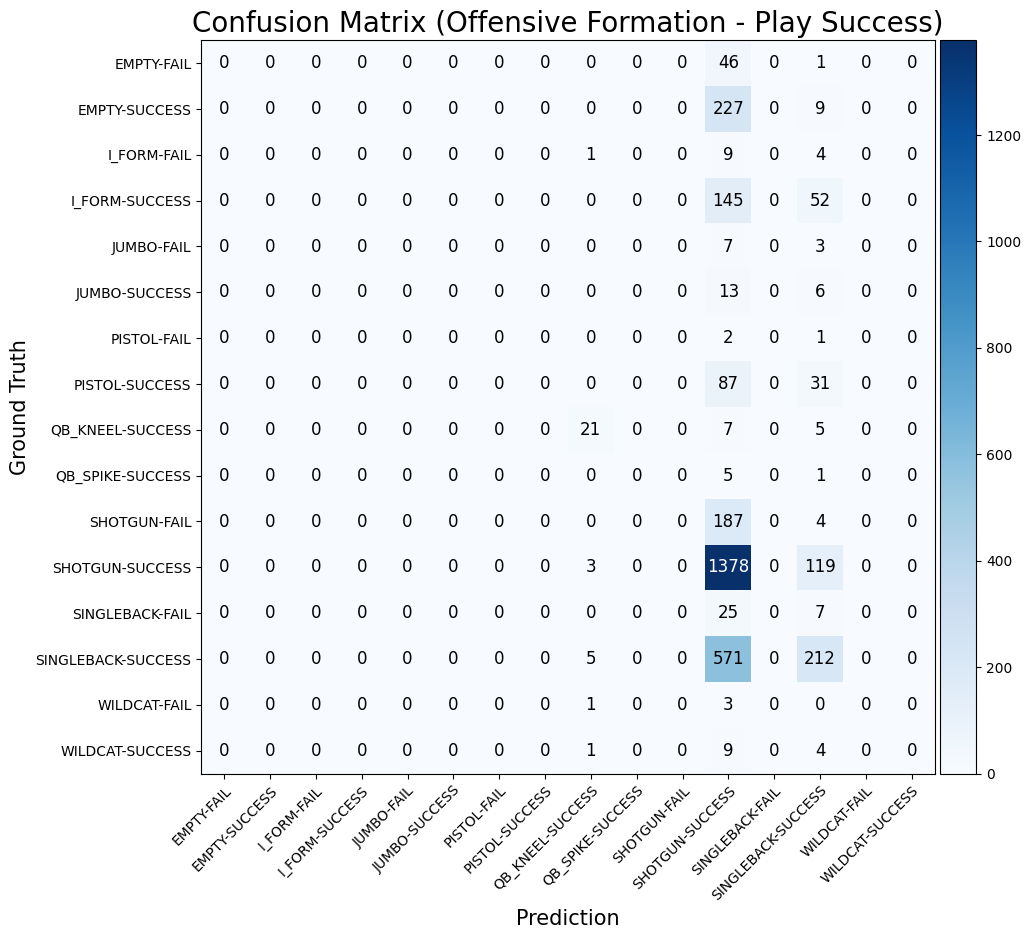

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Ensure label_str and pred_str are numpy arrays
label_str = np.array(label_str)
pred_str = np.array(pred_str)

# Convert string labels to integers
encoder = LabelEncoder()
all_labels = np.unique(np.concatenate((label_str, pred_str)))  # Get all unique labels
encoder.fit(all_labels)
label_int = encoder.transform(label_str)
pred_int = encoder.transform(pred_str)

# Compute confusion matrix
cm = confusion_matrix(label_int, pred_int)

# Plot the confusion matrix with raw counts
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.figure.colorbar(im, ax=ax, cax=cax)

# Set labels
ax.set(xticks=np.arange(len(all_labels)),
       yticks=np.arange(len(all_labels)),
       xticklabels=all_labels, yticklabels=all_labels)

ax.set_title('Confusion Matrix (Offensive Formation - Play Success)', fontsize=20)
ax.set_ylabel('Ground Truth', fontsize=15)
ax.set_xlabel('Prediction', fontsize=15)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate matrix with raw count values
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}", ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=12)

plt.show()


In [57]:
label_str

['SHOTGUN-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'EMPTY-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'I_FORM-FAIL',
 'EMPTY-FAIL',
 'SHOTGUN-FAIL',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-FAIL',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'PISTOL-SUCCESS',
 'PISTOL-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'PISTOL-SUCCESS',
 'PISTOL-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'QB_SPIKE-SUCCESS',
 'EMPTY-SUCCESS',
 'EMPTY-SUCCESS',
 'SINGLEBACK-SUCCESS',
 'SHOTGUN-FAIL',
 'PISTOL-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-SUCCESS',
 'SHOTGUN-FAIL',
 'EMPTY-SUCCESS',
 'SHOTGUN-SUCCESS',
 'S

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix

# Example truth maps (replace these with your actual maps)
# For instance, suppose:
#   of_truthmap = {0: 'Formation_A', 1: 'Formation_B'}
#   os_truthmap = {0: 'Fail', 1: 'Success'}
of_truthmap = {0: 'Formation_A', 1: 'Formation_B'}
os_truthmap = {0: 'Fail', 1: 'Success'}

# Assuming preds_of, label_of, preds_os, label_os are already populated lists
# collected during model evaluation (each element is a numpy array).

# Flatten the arrays consistently using np.concatenate and squeeze
label_of_flat = np.concatenate(label_of, axis=0).squeeze()   # shape (N,)
preds_of_flat = np.concatenate(preds_of, axis=0).squeeze()     # shape (N,)
label_os_flat = np.concatenate(label_os, axis=0).squeeze()     # shape (N,)
preds_os_flat = np.concatenate(preds_os, axis=0).squeeze()     # shape (N,)

# Map indices to string labels using the provided truth maps.
# Use .item() to ensure each element is converted to a Python scalar.
label_form_str = [of_truthmap[int(i.item())] for i in label_of_flat]
pred_form_str  = [of_truthmap[int(i.item())] for i in preds_of_flat]
label_scs_str  = [os_truthmap[int(i.item())] for i in label_os_flat]
pred_scs_str   = [os_truthmap[int(i.item())] for i in preds_os_flat]

# Combine the two parts into a single label for each sample.
# Adjust the order of concatenation if needed.
label_str = [f"{of}-{os}" for of, os in zip(label_form_str, label_scs_str)]
pred_str  = [f"{of}-{os}" for of, os in zip(pred_form_str, pred_scs_str)]

# Optionally, print a few samples to verify the mappings.
print("Sample mappings:")
for i in range(min(5, len(label_str))):
    print(f"GT: {label_str[i]}  |  Pred: {pred_str[i]}")

# Compute the confusion matrix.
# Use unique labels from the ground truth to set the order.
unique_labels = np.unique(label_str)
cm = confusion_matrix(label_str, pred_str, labels=unique_labels)

# (Optional) Normalize the confusion matrix.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix.
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.figure.colorbar(im, ax=ax, cax=cax)

# Set tick marks and labels.
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=unique_labels, yticklabels=unique_labels)

ax.set_title('Confusion Matrix (Offensive Formation - Play Success)', fontsize=20)
ax.set_ylabel('Ground Truth', fontsize=15)
ax.set_xlabel('Prediction', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


KeyError: 6